In [1]:
import os
os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=24'

#from jax.config import config; config.update("jax_enable_x64", True)

%load_ext autoreload
%autoreload 2

from brax import envs
from brax.io import html
from brax.training import normalization

import flax
import jax
import jax.numpy as jnp
from brax.envs import create_fn

from IPython.display import HTML, clear_output

import optax

import matplotlib.pyplot as plt
import numpy as np

from controllers import GruController, MlpController, LinearController
from common import do_local_apg, add_guassian_noise, add_guassian_noise_mixed_std, do_one_rollout

from functools import partial

jax.config.update('jax_platform_name', 'cpu')

def visualize(sys, qps, height=480):
  """Renders a 3D visualization of the environment."""
  return HTML(html.render(sys, qps, height=height))

len(jax.devices())

1

In [11]:
episode_length = 500
action_repeat = 1
apg_epochs = 75
cem_epochs = 1
batch_size = 1
truncation_length = None
learning_rate = 5e-4
clipping = 1e9

initial_std = 0.01
num_elite = 8
eps_start = 0.01
eps_end = 0.00

eps = eps_start

normalize_observations=True

env_name = "inverted_double_pendulum_swingup"  # @param ['ant', 'humanoid', 'fetch', 'grasp', 'halfcheetah', 'walker2d, 'ur5e', 'reacher', bball_1dof]
env_fn = create_fn(env_name = env_name, action_repeat=action_repeat, batch_size=None, auto_reset=False)
env = env_fn()

policy_size = int(2**jnp.ceil(jnp.log2(env.observation_size*4)))
print(policy_size)

policy = GruController(env.observation_size, env.action_size, policy_size)



128


In [12]:
#policy = LinearController(env.observation_size,env.action_size)
#policy = GruController(env.observation_size, env.action_size, 32)

num_directions = jax.local_device_count()
key = jax.random.PRNGKey(1)
reset_keys = jax.random.split(key, num=num_directions)
noise_keys = jax.random.split(reset_keys[0], num=num_directions)
_, model_key = jax.random.split(noise_keys[0])


normalizer_params, obs_normalizer_update_fn, obs_normalizer_apply_fn = normalization.create_observation_normalizer(
          env.observation_size, normalize_observations, num_leading_batch_dims=1)

add_noise_pmap = jax.pmap(add_guassian_noise_mixed_std, in_axes=(None,None,0))
do_apg_pmap = jax.pmap(do_local_apg, in_axes = (None,None,None,None,0,0,None,None,None,None,None,None), static_broadcasted_argnums=(0,1,2,6,7,8,9,10,11,12))
do_rollout_pmap = jax.pmap(do_one_rollout, in_axes = (None,None,None,0,0,None,None,None), static_broadcasted_argnums=(0,1,5,6,7))

init_states = jax.pmap(env.reset)(reset_keys)
x0 = init_states.obs
h0 = jnp.zeros(env.observation_size)

policy_params = policy.init(model_key, h0, x0)

best_reward = -float('inf')
meta_rewards_list = []

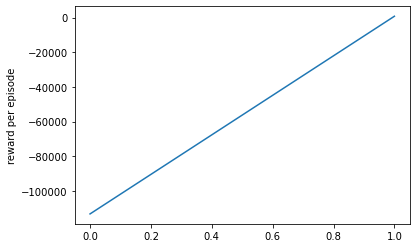

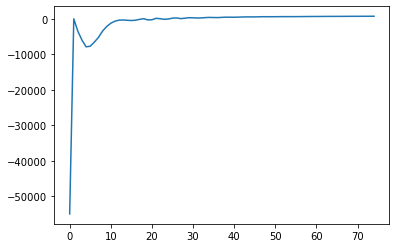

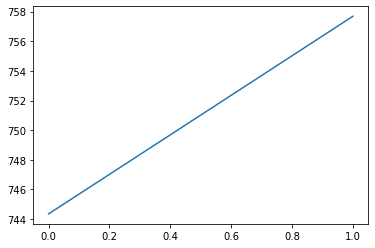

In [ ]:
#%%time
import time

policy_params_flat, policy_params_def = jax.tree_flatten(policy_params)
noise_std = jax.tree_unflatten(policy_params_def, [jnp.ones_like(p)*initial_std for p in policy_params_flat])
best_reward_list = []

n_epochs = 200

for i in range(n_epochs):
    tau = (n_epochs-i)/n_epochs
    eps = tau*eps + (1 - tau)*eps_end
    eps = 0.0
    
    noise_keys = jax.random.split(noise_keys[0], num=num_directions)
    train_keys = jax.random.split(noise_keys[0], num=num_directions)

    policy_params_with_noise, noise = add_noise_pmap(policy_params, noise_std, noise_keys)
    rewards_before, obs, acts, states_before = do_rollout_pmap(env_fn, policy.apply, normalizer_params, policy_params_with_noise, train_keys, episode_length, action_repeat, normalize_observations)
    
    normalizer_params = obs_normalizer_update_fn(normalizer_params, obs[0,:])

    policy_params_with_noise, rewards_lists = do_apg_pmap(apg_epochs, env_fn, policy.apply, normalizer_params, policy_params_with_noise, train_keys, learning_rate, episode_length, action_repeat, normalize_observations, batch_size, clipping, truncation_length)
    rewards_lists = jnp.nan_to_num(rewards_lists, nan=-10_000)
    reward_sums = [jnp.mean(rew[-5:]) for rew in rewards_lists]
    top_idx = sorted(range(len(reward_sums)), key=lambda k: reward_sums[k], reverse=True)
            
    best_reward_list.append(reward_sums[top_idx[0]])    
    
    if i % 1 == 0:
        
        clear_output(wait=True)
        #plt.ylim([min_y, max_y])
        plt.ylabel('reward per episode')
        plt.plot(best_reward_list)
        plt.figure()
        plt.plot(rewards_lists[top_idx[0]])
        plt.show()

        
#         print(f" Iteration {i} --------------------------------")
#         #print(f" Time: {time.time() - start}")

#         for j in range(len(top_idx)):
#             done_idx = jnp.where(states_before.done[top_idx[j], :], size=1)[0].item()
#             if done_idx == 0:
#                 done_idx = rewards_before.shape[-1]
#             rewards_sum_before = jnp.sum(rewards_before[top_idx[j],:done_idx])

#             print(f"{j} : reward: {rewards_sum_before} -> {reward_sums[top_idx[j]]}")
#             if j == num_elite-1:
#                 print("---")
#         print("-------------------------------------------------")
#         print()

    
    cem_rewards = [reward_sums[top_idx[0]]]
    for j in range(cem_epochs):
        top_idx = sorted(range(len(reward_sums)), key=lambda k: reward_sums[k], reverse=True)
        params_with_noise_flat, params_with_noise_def = jax.tree_flatten(policy_params_with_noise)
        params_elite_flat = [p[top_idx[:num_elite], :] for p in params_with_noise_flat]
        
        if any([jnp.any(jnp.isnan(p)) for p in params_elite_flat]):
            asdasdasd

        weights = jnp.array([1/num_elite for _ in range(num_elite)])
        
        #weights = jnp.array([(jnp.log(1 + num_elite)/(k+1)) for k in range(num_elite)])
        #weights = weights/jnp.sum(weights)
        
        new_mean_flat = []
        for elite_params in params_elite_flat:
            weights = weights.reshape((num_elite, *[1 for _ in range(len(elite_params.shape)-1)]))
            new_mean_flat.append(jnp.sum(weights*elite_params, axis=0))

        new_var_flat = []
        for old_params, elite_params in zip(policy_params_flat, params_elite_flat):
            new_var = (old_params - elite_params)**2 + eps
            weights = weights.reshape((num_elite, *[1 for _ in range(len(new_var.shape)-1)]))
            new_var_flat.append(jnp.sqrt(jnp.sum(weights*new_var,axis=0)))

        noise_keys = jax.random.split(noise_keys[0], num=num_directions)
        noise_std = jax.tree_unflatten(policy_params_def, new_var_flat)
        policy_params = jax.tree_unflatten(policy_params_def, new_mean_flat)   
        policy_params_flat, policy_params_def = jax.tree_flatten(policy_params)
        rewards, obs, acts, states_before = do_one_rollout(env_fn, policy.apply, normalizer_params, policy_params, train_keys[0], episode_length, action_repeat, normalize_observations)
        cem_rewards.append(jnp.sum(rewards))


        policy_params_with_noise, noise = add_noise_pmap(policy_params, noise_std, noise_keys)
        rewards, obs, acts, states_before = do_rollout_pmap(env_fn, policy.apply, normalizer_params, policy_params_with_noise, train_keys, episode_length, action_repeat, normalize_observations)
        reward_sums = jnp.sum(rewards, axis=1)
        #cem_rewards.append(reward_sums[top_idx[0]])


        #reward_sums = jnp.nan_to_num(reward_sums)
        
    plt.figure()
    plt.plot(cem_rewards)
    plt.show()

In [ ]:
plt.plot(best_reward_list)
plt.figure()
plt.plot(rewards_lists[top_idx[0]])

In [ ]:
import brax.jumpy as jp
@jax.jit
def do_rnn_rollout(policy_params, normalizer_params, key):
    init_state = env.reset(key)
    h0 = jp.zeros_like(init_state.obs)

    def do_one_rnn_step(carry, step_idx):
        state, h, policy_params, normalizer_params  = carry

        normed_obs = obs_normalizer_apply_fn(normalizer_params, state.obs)
        h1 , actions = policy.apply(policy_params, h, normed_obs)
        #actions = jp.ones_like(actions)*0.0
        nstate = env.step(state, actions)    
        #h1 = jax.lax.cond(nstate.done, lambda x: jnp.zeros_like(h1), lambda x: h1, None)
        return (jax.lax.stop_gradient(nstate), h1, policy_params, normalizer_params), (nstate.reward,state.obs, actions, nstate)


    _, (rewards, obs, acts, states) = jp.scan(
        do_one_rnn_step, (init_state, h0, policy_params, normalizer_params),
        (jnp.array(range(episode_length // action_repeat))),
        length=episode_length // action_repeat)

    return rewards, obs, acts, states

In [ ]:
key, reset_key = jax.random.split(key)
(rewards, obs, acts, states) = do_rnn_rollout(policy_params, normalizer_params, reset_key)

done_idx = jnp.where(states.done, size=1)[0].item()
if done_idx == 0:
    done_idx = states.done.shape[0]
rewards_sum = jnp.sum(rewards[:done_idx])

plt.plot(obs[:,0]);
plt.figure()

plt.plot(acts);
print(rewards_sum)
print(states.done)

In [ ]:
qp_flat, qp_def = jax.tree_flatten(states.qp)

qp_list = []

for i in range(qp_flat[0].shape[0]):
    qpc=[]
    for thing in qp_flat:
        qpc.append(thing[i,:])
    qp_list.append(jax.tree_unflatten(qp_def, qpc))
    

visualize(env.sys, qp_list, height=800)

In [ ]:
plt.plot(best_reward_list)

In [ ]:
policy_params_with_noise, rewards_lists = do_apg_pmap(300, env_fn, policy.apply, normalizer_params, policy_params_with_noise, train_keys, learning_rate, episode_length, action_repeat, normalize_observations, batch_size, clipping, truncation_length)
reward_sums = [rew[-1] for rew in rewards_lists]
top_idx = sorted(range(len(reward_sums)), key=lambda k: reward_sums[k], reverse=True)

In [ ]:
policy_params_trained = policy_params_with_noise
_, params_def = jax.tree_flatten(policy_params)
params_flat, _ = jax.tree_flatten(policy_params_trained)
top_params_flat = [param[top_idx[0]] for param in params_flat]
top_params = jax.tree_unflatten(params_def, top_params_flat)

In [ ]:
plt.plot(rewards_lists[top_idx[0],:])

In [ ]:
key, reset_key = jax.random.split(key)
(rewards, obs, acts, states) = do_rnn_rollout(top_params, normalizer_params, reset_key)

done_idx = jnp.where(states.done, size=1)[0].item()
if done_idx == 0:
    done_idx = states.done.shape[0]
rewards_sum = jnp.sum(rewards[:done_idx])

plt.plot(obs[:,0]);
plt.figure()

plt.plot(acts);
print(rewards_sum)
print(states.done)

In [ ]:
qp_flat, qp_def = jax.tree_flatten(states.qp)

qp_list = []
for i in range(qp_flat[0].shape[0]):
    qpc=[]
    for thing in qp_flat:
        qpc.append(thing[i,:])
    qp_list.append(jax.tree_unflatten(qp_def, qpc))
    

visualize(env.sys, qp_list, height=800)